In [1]:
# Parameters
scale = 4               # domain size mulitplier
reynoldsNumber = 1000
TRT = True              # Enable two relaxation time (False == BGK/SRT)
aspectRatio = 1         # NY/NX ratio
nMsg = 1000 * scale ** 2 # status update frequency
relaxationCoeff = 1     # Under-relaxation coefficient.  Keep at 1 to disable, or below 1 to under-relax

# Constants
nThreads = 32         # GPU threads
nX = nThreads * scale
nY = aspectRatio * nX
uMax = 0.1
nu = uMax * nX / reynoldsNumber
tau = nu * 3 + 0.5
cs = 1.0 / (3.0 ** 0.5)
mach = uMax / cs
omega = 1.0 / tau
q = 9
nSteps = 1.0E8
threshold = 1.0E-15  # Convergence threshold
df0 = 1.0
magic = 0.25
omegaMinus  = 1.0 / (0.5 + (magic / (tau - 0.5)))

oclOptions=['-cl-no-signed-zeros','-cl-strict-aliasing', '-cl-mad-enable']



# Print Simulation Information
print("Simulating 2D Lid-driven cavity")
print("      domain size: %u x %u" % (nX, nY))
print("               nu: %g"      % nu)
print("              tau: %g"      % tau)
print("            u_max: %g"      % uMax)
print("             Mach: %g"      % (mach))
print("    message every: %u steps" % nMsg)

Simulating 2D Lid-driven cavity
      domain size: 128 x 128
               nu: 0.0128
              tau: 0.5384
            u_max: 0.1
             Mach: 0.173205
    message every: 16000 steps


In [2]:
import numpy as np
import pyopencl as cl
from pyopencl import array as gpuarray
from pyopencl.reduction import ReductionKernel
from time import time

nX = int(nX)
nY = int(nY)
nXnY = nX * nY

# Spitting domain on GPU
localWorkSize = (nThreads, 1, 1)  # block size
globalWorkSize = (scale, nY, 1)   # grid size

# Intialize cl and print information
platformIndex = 0 # Assuming platform #0
deviceIndex = 0   # Assuming device #0
platform = cl.get_platforms()[platformIndex]
device = platform.get_devices()[deviceIndex]
deviceInfo = cl.device_info
ctx = cl.create_some_context()
queue = cl.CommandQueue(ctx)
bytesPerGiB = 1073741824

# get GPU property
def gpuProperty(propertyName):
    return device.get_info(getattr(deviceInfo, propertyName))

print("OpenCL information:")
print("      using platform: %d"        % platformIndex)
print("        using device: %d"        % deviceIndex)
print("                name: %s %s"     % (platform.name, device.name))
print("             version: %s"        % (gpuProperty("VERSION")))
print("           C version: %s"        % (gpuProperty("OPENCL_C_VERSION")))
print("  compute capability: %d.%d"     % (gpuProperty("COMPUTE_CAPABILITY_MAJOR_NV"),gpuProperty("COMPUTE_CAPABILITY_MINOR_NV")))
print("       compute units: %d"        % gpuProperty("MAX_COMPUTE_UNITS"))
print("       global memory: %.1f GiB"   % (gpuProperty("GLOBAL_MEM_SIZE") / (bytesPerGiB)))

# Allocate memory
doubleType = cl.cltypes.double
f0GPU   = gpuarray.zeros(queue, nXnY, doubleType)
f1GPU   = gpuarray.zeros(queue, nXnY * (q-1), doubleType)
f2GPU   = gpuarray.zeros(queue, nXnY * (q-1), doubleType)
rhoGPU  = gpuarray.zeros(queue, nXnY, doubleType).fill(1.0)
uGPU    = gpuarray.zeros(queue, nXnY, doubleType)
vGPU    = gpuarray.zeros(queue, nXnY, doubleType)

OpenCL information:
      using platform: 0
        using device: 0
                name: NVIDIA CUDA GeForce GTX 970
             version: OpenCL 1.2 CUDA
           C version: OpenCL C 1.2 
  compute capability: 5.2
       compute units: 13
       global memory: 3.9 GiB


In [3]:
# Function Definitions

definew0 = """const double w0 = 4.0 / 9.0;"""
definews = """const double ws = 1.0 / 9.0;"""
definewd = """const double wd = 1.0 / 36.0;"""

# Index function for nX x nY domain
gpuField0Index = """
size_t gpu_field0_index(const size_t x, const size_t y)
{{
    return {nX:d} * y + x;
}}
""".format(nX=nX)

# Index function for nX x nY x Q domain
gpuFieldNIndex = """
size_t gpu_fieldn_index(const size_t x, const size_t y, const size_t d)
{{
    return ({nX:d} * ( {nY:d} * (d - 1) + y) + x);
}}
""".format(nX=nX, nY=nY)

# Compute equilibrium distribution
gpuSingleFeq = """
double gpu_single_feq(const double w, const double drho, const double cdotu, const double wu2x15)
{
    return w * (drho + (3.0 * cdotu) + (4.5 * (cdotu * cdotu))) - wu2x15;
}
"""

# Initial condition equilibrium distribtion
gpuInitEquilibriumKernel = gpuSingleFeq + gpuField0Index + gpuFieldNIndex + """
__kernel void function(__global double *f0, __global double *f1, __global const double *r, __global const double *u, __global const double *v)
{
    
   """ + definew0 + definews + definewd +  """
    const size_t x = get_global_id(0);
    const size_t y = get_group_id(1);

    const size_t zeroIndex = gpu_field0_index(x, y);
    
    const double drho = r[zeroIndex] - 1.0;
    const double ux   = u[zeroIndex];
    const double uy   = v[zeroIndex];
    
    const double u2x15 = 1.5 * (ux * ux + uy * uy);
    const double wsu2x15 = ws * u2x15;
    const double wdu2x15 = wd * u2x15;
    
    f0[zeroIndex] = w0 * (drho - u2x15);
    f1[gpu_fieldn_index(x, y, 1)]  = gpu_single_feq(ws, drho, ux, wsu2x15);
    f1[gpu_fieldn_index(x, y, 2)]  = gpu_single_feq(ws, drho, uy, wsu2x15);
    f1[gpu_fieldn_index(x, y, 3)]  = gpu_single_feq(ws, drho, -ux, wsu2x15);
    f1[gpu_fieldn_index(x, y, 4)]  = gpu_single_feq(ws, drho, -uy, wsu2x15);
    f1[gpu_fieldn_index(x, y, 5)]  = gpu_single_feq(wd, drho, ux + uy, wdu2x15);
    f1[gpu_fieldn_index(x, y, 6)]  = gpu_single_feq(wd, drho, uy - ux, wdu2x15);
    f1[gpu_fieldn_index(x, y, 7)]  = gpu_single_feq(wd, drho, -(ux + uy), wdu2x15);
    f1[gpu_fieldn_index(x, y, 8)]  = gpu_single_feq(wd, drho, ux - uy, wdu2x15);
}
"""
gpuInitEquilibrium = cl.Program(ctx, gpuInitEquilibriumKernel).build(options=oclOptions)

# Calculate sum of squares of Solution Error
sumSquaresErrorKernel = ReductionKernel(ctx, doubleType, neutral="0", reduce_expr="a + b", map_expr="(x[i] - y[i]) * (x[i] - y[i])", arguments="__global double *x, __global double *y")

# Compute and report convergence
def convergence(time):
    global df0
    
    diffDistributions = sumSquaresErrorKernel(f1GPU,f2GPU).get()
    if time == 0:
        print('Time\t\tDiff')
        df0 = diffDistributions
    diffDistributions /= df0
    
    print('%.2e\t%.2e' % (time, diffDistributions))
    return (diffDistributions < threshold or np.isnan(diffDistributions))


streamAndCollideKernel = gpuFieldNIndex + gpuField0Index + gpuSingleFeq + """
__kernel void function(__global double *f0, __global const double *f1, __global double *f2, const unsigned int NX,const unsigned int NY, const unsigned int TRT, const double tauinv, const double u_max, const double tauinvMinus, const double relax)
{
    """ + definew0 + definews + definewd + """
    
    const size_t x = get_global_id(0);
    const size_t y = get_group_id(1);
    const size_t xp1 = x + 1;
    const size_t yp1 = y + 1;
    const int ym1 = y - 1;
    
    // direction numbering scheme
    // 6 2 5
    // 3 0 1
    // 7 4 8
    
    const size_t fieldZeroIndex = gpu_field0_index(x,y);
    double ft0 = f0[fieldZeroIndex];
    
    // Streaming and Bounce-back BC
    double ft1,ft2,ft3,ft4,ft5,ft6,ft7,ft8;
    
    //  Interior
    if (x > 0) {
        const size_t xm1 = x - 1;
        ft1 = f1[gpu_fieldn_index(xm1, y, 1)];
        
        if (y > 0)
            ft5 = f1[gpu_fieldn_index(xm1, ym1, 5)];
        
        if (yp1 < NY)
            ft8 = f1[gpu_fieldn_index(xm1, yp1, 8)];
    }
    
    // Left Wall
    else {
        ft1 = f1[gpu_fieldn_index(x, y, 3)];
        ft5 = f1[gpu_fieldn_index(x, y, 7)];
        ft8 = f1[gpu_fieldn_index(x, y, 6)];
    }
    
    // Interior
    if (xp1 < NX) {
        ft3 = f1[gpu_fieldn_index(xp1, y, 3)];
        
        if (y > 0)
            ft6 = f1[gpu_fieldn_index(xp1, ym1, 6)];
        
        if (yp1 < NY)
            ft7 = f1[gpu_fieldn_index(xp1, yp1, 7)];
    }
    
    // Right Wall
    else {
        ft3 = f1[gpu_fieldn_index(x, y, 1)];
        ft6 = f1[gpu_fieldn_index(x, y, 8)];
        ft7 = f1[gpu_fieldn_index(x, y, 5)];
    }
    
    // Interior
    if (y > 0)
        ft2 = f1[gpu_fieldn_index(x,   ym1, 2)];
    
    // Bottom Wall
    else {
        ft2 = f1[gpu_fieldn_index(x, y, 4)];
        ft5 = f1[gpu_fieldn_index(x, y, 7)];
        ft6 = f1[gpu_fieldn_index(x, y, 8)];
    }
    
    // Interior
    if (yp1 < NY)
        ft4 = f1[gpu_fieldn_index(x, yp1, 4)];       
    
    // Top Wall
    else {
        const double topWallTerm = 6.0 * wd * u_max;
        ft4 = f1[gpu_fieldn_index(x, y, 2)];
        ft7 = f1[gpu_fieldn_index(x, y, 5)] - topWallTerm;
        ft8 = f1[gpu_fieldn_index(x, y, 6)] + topWallTerm;
    }
    
    // Macroscopic Variables
    // compute moments
    const double drho = ft0 + ft1 + ft2 + ft3 + ft4 + ft5 + ft6 + ft7 + ft8;
    const double ux = ft1 + ft5 + ft8 - (ft3 + ft6 + ft7);
    const double uy = ft2 + ft5 + ft6 - (ft4 + ft7 + ft8);
    
    double fnew[9]; // Temporary storage of new distribution
     
    // Collision
    // Two relaxation time (TRT)
    // w * (drho + (3.0 * cdotu) + (4.5 * (cdotu * cdotu))) - wu2x15;
    if (TRT == 1) {
        double fplus, fminus, feqTerm1, feqTerm2, cdotu;
        const double halftauinv = 0.5 * tauinv;
        const double halftuinvMinus = 0.5 * tauinvMinus;
        const double u2x15 = 1.5 * ((ux * ux) + (uy * uy));
        const double wsu2x15 = ws * u2x15;
        const double wdu2x15 = wd * u2x15;
        const double wsdrho = ws * drho;
        const double wddrho = wd * drho;
        
        // k = 0
        fnew[0] = ft0 - tauinv * (ft0 - w0 * (drho - u2x15));
        
        // k = 1,3
        cdotu = ux;
        feqTerm1 = wsdrho + ws * (4.5 * (cdotu * cdotu)) - wsu2x15;
        feqTerm2 = 3.0 * ws * cdotu;
        fplus = halftauinv * ((ft1 + ft3) - 2 * feqTerm1);
        fminus = halftuinvMinus * ((ft1 - ft3) - 2 * feqTerm2);
        fnew[1] = ft1 - fplus - fminus;
        fnew[3] = ft3 - fplus + fminus;
        
        // k = 2,4
        cdotu = uy;
        feqTerm1 = wsdrho + ws * (4.5 * (cdotu * cdotu)) - wsu2x15;
        feqTerm2 = 3.0 * ws * cdotu;
        fplus = halftauinv * ((ft2 + ft4) - 2 * feqTerm1);
        fminus = halftuinvMinus * ((ft2 - ft4) - 2 * feqTerm2);
        fnew[2] = ft2 - fplus - fminus;
        fnew[4] = ft4 - fplus + fminus;
        
        // k = 5,7
        cdotu = ux + uy;
        feqTerm1 = wddrho + wd * (4.5 * (cdotu * cdotu)) - wdu2x15;
        feqTerm2 = 3.0 * wd * cdotu;
        fplus = halftauinv * ((ft5 + ft7) - 2 * feqTerm1);
        fminus = halftuinvMinus * ((ft5 - ft7) - 2 * feqTerm2);
        fnew[5] = ft5 - fplus - fminus;
        fnew[7] = ft7 - fplus + fminus;
        
        // k = 6,8
        cdotu = -ux + uy;
        feqTerm1 = wddrho + wd * (4.5 * (cdotu * cdotu)) - wdu2x15;
        feqTerm2 = 3.0 * wd * cdotu;
        fplus = halftauinv * ((ft6 + ft8) - 2 * feqTerm1);
        fminus = halftuinvMinus * ((ft6 - ft8) - 2 * feqTerm2);
        fnew[6] = ft6 - fplus - fminus;
        fnew[8] = ft8 - fplus + fminus;
    }
    
    // SRT/BGK
    else {     
        const double u2x15 = 1.5 * ((ux * ux) + (uy * uy));
        const double wsu2x15 = ws * u2x15;
        const double wdu2x15 = wd * u2x15;
        const double omtauinv =  1.0 - tauinv;
        fnew[0] = omtauinv * ft0 + tauinv * w0 * (drho - u2x15);
        fnew[1] = omtauinv * ft1 + tauinv * gpu_single_feq(ws, drho, ux, wsu2x15);
        fnew[2] = omtauinv * ft2 + tauinv * gpu_single_feq(ws, drho, uy, wsu2x15);
        fnew[3] = omtauinv * ft3 + tauinv * gpu_single_feq(ws, drho, -ux, wsu2x15);
        fnew[4] = omtauinv * ft4 + tauinv * gpu_single_feq(ws, drho, -uy, wsu2x15);
        fnew[5] = omtauinv * ft5 + tauinv * gpu_single_feq(wd, drho, ux + uy, wdu2x15);
        fnew[6] = omtauinv * ft6 + tauinv * gpu_single_feq(wd, drho, -ux + uy, wdu2x15);
        fnew[7] = omtauinv * ft7 + tauinv * gpu_single_feq(wd, drho, -ux - uy, wdu2x15);
        fnew[8] = omtauinv * ft8 + tauinv * gpu_single_feq(wd, drho,  ux - uy, wdu2x15);
    }
    
    // Save distribution
    const size_t nXnY = NX * NY;
    
    if (relax != 1.0){
        const double relax2 = 1.0 - relax;
        f0[fieldZeroIndex] = relax2 * ft0 + relax * fnew[0];
        size_t idx;
        for (size_t k = 1; k < 9; k++) {
            idx = fieldZeroIndex + (k-1) * nXnY;
            f2[idx] = relax2 * f1[idx] + relax * fnew[k];
        }
    }
    else {
        f0[fieldZeroIndex] = fnew[0];
        for (size_t k = 1; k < 9; k++)
            f2[fieldZeroIndex + (k-1) * nXnY] = fnew[k];
    }
}
    """
streamAndCollide = cl.Program(ctx, streamAndCollideKernel).build(options=oclOptions)

# Compute macro variables
saveMacroVarsKernel = gpuField0Index + """
__kernel void function(__global const double *f0, __global const double *f2, __global double *r, __global double *u, __global double *v, const unsigned int nXnY)
{
    const size_t x = get_global_id(0);
    const size_t y = get_group_id(1);

    const size_t scalarIndex = gpu_field0_index(x, y);
    
    const double f20 = f2[scalarIndex];
    const double f21 = f2[scalarIndex + nXnY];
    const double f22 = f2[scalarIndex + 2 * nXnY];
    const double f23 = f2[scalarIndex + 3 * nXnY];
    const double f24 = f2[scalarIndex + 4 * nXnY];
    const double f25 = f2[scalarIndex + 5 * nXnY];
    const double f26 = f2[scalarIndex + 6 * nXnY];
    const double f27 = f2[scalarIndex + 7 * nXnY];
    
    r[scalarIndex] = 1.0 + f0[scalarIndex] + f20 + f21 + f22 + f23 + f24 + f25 + f26 + f27;
    u[scalarIndex] = f20 - f22 + f24 - f25 - f26 + f27;
    v[scalarIndex] = f21 - f23 + f24 + f25 - f26 - f27;
}
"""
saveMacroVars = cl.Program(ctx, saveMacroVarsKernel).build(options=oclOptions)


In [4]:
# Initialize Domain

# Initialize f at equilibrium
gpuInitEquilibrium.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f1GPU.data, rhoGPU.data, uGPU.data, vGPU.data, g_times_l=True)

# Record start time
cpuStart = time()

# Main Loop
for t in range(0, int(nSteps)):
    msg = (t % nMsg == 0)
    if (t % 2 == 0): # f1 and f2 arguments swapped
        streamAndCollide.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f1GPU.data, f2GPU.data,cl.cltypes.uint(nX),cl.cltypes.uint(nY),cl.cltypes.uint(TRT),doubleType(omega),doubleType(uMax),doubleType(omegaMinus),doubleType(relaxationCoeff), g_times_l=True)
    else:
        streamAndCollide.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f2GPU.data, f1GPU.data,cl.cltypes.uint(nX),cl.cltypes.uint(nY),cl.cltypes.uint(TRT),doubleType(omega),doubleType(uMax),doubleType(omegaMinus),doubleType(relaxationCoeff), g_times_l=True)
    if msg and convergence(t):
        break;
        
cpuStop = time() 
saveMacroVars.function(queue, globalWorkSize, localWorkSize, f0GPU.data, f2GPU.data, rhoGPU.data, uGPU.data, vGPU.data, cl.cltypes.uint(nXnY), g_times_l=True)
cpuElapsed = cpuStop - cpuStart # cpu elapsed time in seconds
nodesUpdated = t * nXnY # Number of distribution nodes updated in main loop
speed = nodesUpdated / (1E6 * cpuElapsed) # Lattice updates per second in millions

print('\n ----- performance information -----')
print('               timesteps: %.3g' %  t)
print('           clock runtime: %.3g s' % cpuElapsed)
print('                   speed: %.3g Mlups' % speed)

Time		Diff
0.00e+00	1.00e+00
1.60e+04	2.23e-08
3.20e+04	1.02e-09
4.80e+04	4.68e-11
6.40e+04	2.23e-12
8.00e+04	1.19e-13
9.60e+04	7.85e-15
1.12e+05	6.29e-16

 ----- performance information -----
               timesteps: 1.12e+05
           clock runtime: 8.59 s
                   speed: 214 Mlups


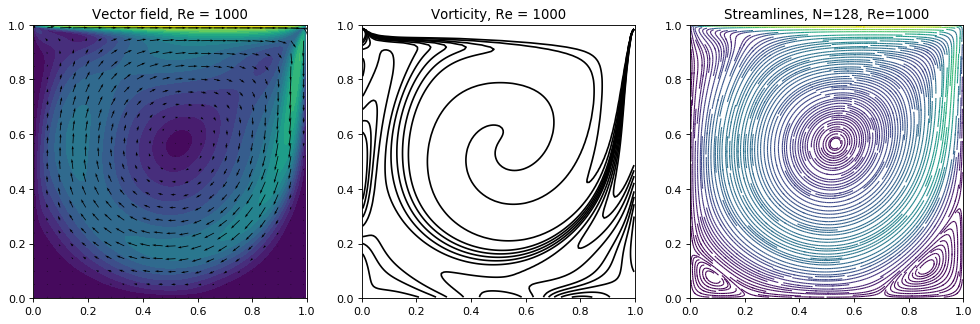

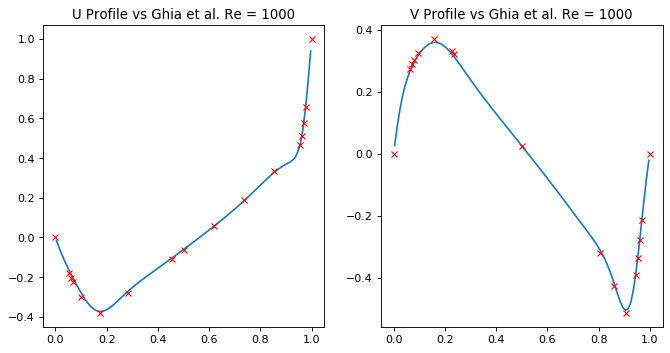

In [6]:
# Generate Plots
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import csv

# Compute properties
rho = rhoGPU.get().reshape(nY, nX)
u = uGPU.get().reshape(nY, nX) / uMax
v = vGPU.get().reshape(nY, nX) / uMax
dx = 1.0 / nX
dy = dx
(x,y) = np.meshgrid(np.linspace(0.5 * dx, 1.0 - 0.5 * dx, nX), np.linspace(0.5 * dy, aspectRatio - 0.5 * dy, nY))
vmag = np.sqrt(u ** 2 + v ** 2)
vort = np.gradient(v, dx, edge_order=2, axis=1) - np.gradient(u, dy, edge_order=2, axis=0)

# Vector field
plt.figure(figsize=(15, 15), dpi = 80)
plt.subplot(1, 3, 1)
plt.contourf(x, y, vmag, 20)
quiverSkip = max(1, np.round(nX / 20).astype(np.int))
plt.quiver(x[::quiverSkip, ::quiverSkip], y[::quiverSkip, ::quiverSkip], u[::quiverSkip, ::quiverSkip], v[::quiverSkip, ::quiverSkip])
_ = plt.axis('scaled')
plt.xlim((0, 1))
plt.ylim((0, aspectRatio))
plt.title('Vector field, Re = {Re}'.format(Re=reynoldsNumber))

# Vorticity contour lines
plt.subplot(1, 3, 2)
litVortLevels = np.array([-3, -2, -1, -0.5, 0, 0.5, 1, 2, 3, 4, 5])
plt.contour(x, y, vort,litVortLevels,colors='k',linestyles='solid')
_ = plt.axis('scaled')
plt.xlim((0, 1))
plt.ylim((0, aspectRatio))
plt.title('Vorticity, Re = {Re}'.format(Re=reynoldsNumber))

# Streamlines
ax0 = plt.subplot(1, 3, 3)
ax0.streamplot(x[0, :], y[:, 0], u, v, density = 4, color = vmag, arrowstyle = '-', minlength = 0.1, linewidth = 1, transform = None)
plt.axis("scaled")
plt.title("Streamlines, N=%d, Re=%d" % (nX, reynoldsNumber))
plt.xlim((0, 1))
plt.ylim((0, aspectRatio))

# Comparison to Ghia et al. results
litRe = [100, 400, 1000, 3200, 5000, 7500, 10000]
if reynoldsNumber in litRe and nX == nY:
    with open('ghiaV.csv', newline='') as csvfile:
        contents =  list(csv.reader(csvfile))
        
    labels = contents.pop(0)
    data = np.array(contents, dtype=np.float32)
    litV = {}
    for i,key in enumerate(labels):
        if i > 0:
            key = int(key)
        litV[key] = data[:,i]
    
    with open('ghiaU.csv', newline='') as csvfile:
        contents =  list(csv.reader(csvfile))
        
    labels = contents.pop(0)
    data = np.array(contents, dtype=np.float32)
    litU = {}
    for i,key in enumerate(labels):
        if i > 0:
            key = int(key)
        litU[key] = data[:, i]

    uInterpolator = RegularGridInterpolator((y[:, 0], x[0, :]), u)
    profile = np.zeros((100, 2))
    profile[:,0] = np.linspace(y[0, 0], y[-1, -1], 100)
    profile[:,1] = np.ones(100) * 0.5
    uprof = uInterpolator(profile)
    plt.figure(figsize=(10, 5), dpi= 80)
    plt.subplot(1, 2, 1)
    plt.plot(profile[:,0], uprof)
    plt.plot(litU['y'], litU[reynoldsNumber],'rx')
    plt.title('U Profile vs Ghia et al. Re = {Re}'.format(Re=reynoldsNumber))

    vInterpolator = RegularGridInterpolator((y[:,0], x[0,:]),v)
    profile = np.zeros((100, 2))
    profile[:,0] = np.ones(100) * 0.5
    profile[:,1] = np.linspace(x[0, 0], x[-1, -1], 100)
    vprof = vInterpolator(profile)
    plt.subplot(1, 2, 2)
    plt.plot(profile[:, 1], vprof)
    plt.plot(litV['x'], litV[reynoldsNumber],'rx')
    plt.title('V Profile vs Ghia et al. Re = {Re}'.format(Re=reynoldsNumber))
